In [5]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

In [6]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 原始SVHN中类别10为填充的数字X, 最多字符为6
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (6 - len(lbl)) * [10]
        
        return img, torch.from_numpy(np.array(lbl[:6]))

    def __len__(self):
        return len(self.img_path)


train_path = glob.glob('../input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('../input/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]


train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=10, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

    
val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                    transforms.Compose([
                       transforms.Resize((64, 128)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=10, 
    shuffle=False, 
    num_workers=10, 
)
    

In [7]:
# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
        # CNN提取特征模块
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),  
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
        self.fc5 = nn.Linear(32*3*7, 11)
        self.fc6 = nn.Linear(32*3*7, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        c6 = self.fc6(feat)
        return c1, c2, c3, c4, c5, c6

 
model = SVHN_Model1()
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0


def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for data in tqdm(train_loader):
        c0, c1, c2, c3, c4, c5 = model(data[0])
        loss = criterion(c0, data[1][:, 0]) + \
                criterion(c1, data[1][:, 1]) + \
                criterion(c2, data[1][:, 2]) + \
                criterion(c3, data[1][:, 3]) + \
                criterion(c4, data[1][:, 4]) + \
                criterion(c5, data[1][:, 5])
        loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)


def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for data in tqdm(val_loader):
            c0, c1, c2, c3, c4, c5 = model(data[0])
            loss = criterion(c0, data[1][:, 0]) + \
                    criterion(c1, data[1][:, 1]) + \
                    criterion(c2, data[1][:, 2]) + \
                    criterion(c3, data[1][:, 3]) + \
                    criterion(c4, data[1][:, 4]) + \
                    criterion(c5, data[1][:, 5])
            loss /= 6
            val_loss.append(loss.item())
    return np.mean(val_loss)


train_loss_plot = list()
val_loss_plot = list()

100%|██████████| 1000/1000 [00:03<00:00, 332.65it/s]


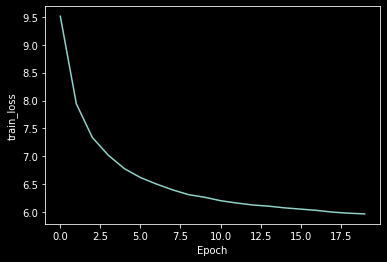

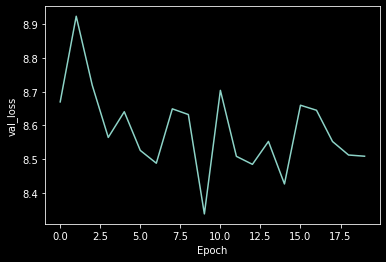

In [8]:
for epoch in range(20):
    print('\nEpoch: ', epoch)

    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(val_loader, model, criterion)
    
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model.pt')
        
    train_loss_plot.append(train_loss)
    val_loss_plot.append(val_loss)
    

plt.plot(train_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("train_loss")
plt.show()

plt.plot(val_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("val_loss")
plt.show()

In [ ]:
model.load_state_dict(torch.load(' model.pt')) 